In [139]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

orig_df = pd.read_csv(r'..//data//orig.csv')
orig_df.insert(loc=0, column='id', value=0) # Add id to first col to match new train

# cat_features = []
# train_df[cat_features] = train_df[cat_features].astype('category')
# test_df[cat_features] = test_df[cat_features].astype('category')

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)
orig_df = prepare_data(orig_df, is_train=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
orig_df.columns = [f"{c}_orig" for c in orig_df.columns]
orig_df_columns = orig_df.columns.to_list()

train_df = train_df.merge(orig_df.loc[(orig_df["weight_capacity_orig"]>5)&(orig_df["weight_capacity_orig"]<30)], left_on='weight_capacity', right_on='weight_capacity_orig', how='left')
test_df = test_df.merge(orig_df.loc[(orig_df["weight_capacity_orig"]>5)&(orig_df["weight_capacity_orig"]<30)], left_on='weight_capacity', right_on='weight_capacity_orig', how='left')

In [ ]:
# train_df = train_df.merge(orig_df.groupby("weight_capacity_orig", as_index=False)[f'{target}_orig'].mean(), left_on='weight_capacity', right_on='weight_capacity_orig', how='left')

In [ ]:
# test_df = test_df.merge(orig_df.groupby("weight_capacity_orig", as_index=False)[f'{target}_orig'].mean(), left_on='weight_capacity', right_on='weight_capacity_orig', how='left')

In [73]:
train_df['y_pred'] = train_df['price'].mean()
root_mean_squared_error(train_df['y_pred'], train_df['price'])

38.93867923358144

In [74]:
train_df['y_pred'] = train_df['price_orig'].fillna(train_df['price'].mean())
root_mean_squared_error(train_df['y_pred'], train_df['price'])

45.52269904191155

In [78]:
len(train_df[train_df['price_orig'].isna()]), len(train_df[~train_df['price_orig'].isna()]) 

(2275542, 1718776)

In [63]:
# orig_df = orig_df.groupby("weight_capacity")[target].mean()
# orig_df.name = "orig_{target}"

In [53]:
orig_df.loc[
    (orig_df["weight_capacity"] < 5)
    & ~(orig_df["weight_capacity"] == -1)
]

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price


In [54]:
orig_df[orig_df['weight_capacity'] == -1][target].mean()

81.8591415231958

In [55]:
train_df[train_df['weight_capacity'] == -1][target].mean()

66.03232040929204

In [3]:
# col1 = 'brand'
col1 = 'material'
col2 = 'is_waterproof'
stats = ['mean', 'skew', 'var', 'count']

agg_stats = train_df.groupby(col1)[col2].agg(stats)
agg_stats

,mean,skew,var,count
material,,,,
-1,0.482679,-0.208553,0.276631,110962
0,0.470462,-0.320208,0.296113,976186
1,0.468796,-0.316200,0.296348,942656
2,0.468634,-0.333528,0.298894,1060882
3,0.468095,-0.309644,0.295763,903632


In [ ]:
# import itertools

# best_pairs = ['material_is_waterproof', 'material_laptop_compartment', 'material_size', 'material_style', 'is_waterproof_color', 'style_color',]

# cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
# for col1, col2 in itertools.combinations(cols, 2):
#     combined_col_name = f"{col1}_{col2}"

#     if combined_col_name not in best_pairs:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
#     )#.astype('category')

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
#     )#.astype('category')

# best_trios = ['material_laptop_compartment_is_waterproof', 'material_laptop_compartment_style', 'material_is_waterproof_style', 'material_size_laptop_compartment', 'laptop_compartment_is_waterproof_color']

# for col1, col2, col3 in itertools.combinations(cols, 3):
#     combined_col_name = f"{col1}_{col2}_{col3}"

#     if combined_col_name not in best_trios:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" +
#         train_df[col2].astype(str) + "_" +
#         train_df[col3].astype(str)
#     )

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + 
#         test_df[col2].astype(str) + "_" +
#         test_df[col3].astype(str)
#     )

# best_quartet = ['material_size_laptop_compartment_is_waterproof', 'material_laptop_compartment_is_waterproof_style', 'brand_laptop_compartment_is_waterproof_style', 'material_laptop_compartment_is_waterproof_color', 'brand_material_laptop_compartment_is_waterproof']

# for col1, col2, col3, col4 in itertools.combinations(cols, 4):
#     combined_col_name = f"{col1}_{col2}_{col3}_{col4}"

#     if combined_col_name not in best_quartet:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" +
#         train_df[col2].astype(str) + "_" +
#         train_df[col3].astype(str) + "_" +
#         train_df[col4].astype(str)
#     )

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + 
#         test_df[col2].astype(str) + "_" +
#         test_df[col3].astype(str) + "_" +
#         test_df[col4].astype(str)
#     )

In [ ]:
import itertools

def create_comb_features(train_df, test_df, cols, allowed_features, comb_size):
    for comb in itertools.combinations(cols, comb_size):
        col_name = "_".join(comb)
        if col_name not in allowed_features:
            continue
        # Create the new feature by joining the selected columns row-wise
        train_df[col_name] = train_df[list(comb)].astype(str).agg('_'.join, axis=1)
        test_df[col_name] = test_df[list(comb)].astype(str).agg('_'.join, axis=1)


best_2 = [
    'material_is_waterproof', 'material_laptop_compartment',
    'material_size', 'material_style', 'is_waterproof_color', 'style_color'
]
best_3 = [
    'material_laptop_compartment_is_waterproof', 'material_laptop_compartment_style',
    'material_is_waterproof_style', 'material_size_laptop_compartment', 'laptop_compartment_is_waterproof_color'
]
best_4 = [
    'material_size_laptop_compartment_is_waterproof', 'material_laptop_compartment_is_waterproof_style',
    'brand_laptop_compartment_is_waterproof_style', 'material_laptop_compartment_is_waterproof_color',
    'brand_material_laptop_compartment_is_waterproof'
]

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
create_comb_features(train_df, test_df, cols, best_2, 2)
create_comb_features(train_df, test_df, cols, best_3, 3)
create_comb_features(train_df, test_df, cols, best_4, 4)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 27 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   brand                                            int64  
 1   material                                         int64  
 2   size                                             int64  
 3   compartments                                     int64  
 4   laptop_compartment                               int64  
 5   is_waterproof                                    int64  
 6   style                                            int64  
 7   color                                            int64  
 8   weight_capacity                                  float64
 9   price                                            float64
 10  wc_decimal_count                                 int64  
 11  material_size                                    object 
 12  material_lapto

In [114]:
orig_df_columns.to_list()

['brand_orig',
 'material_orig',
 'size_orig',
 'compartments_orig',
 'laptop_compartment_orig',
 'is_waterproof_orig',
 'style_orig',
 'color_orig',
 'weight_capacity_orig',
 'price_orig']

In [ ]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
outer_folds = 5
inner_folds = 20
# FOLDS = 5

target_feature_cols = []
# target_feature_cols = ['weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color', 'laptop_compartment', 'is_waterproof', 'size', 'material', 'style']
target_feature_cols = ['weight_capacity', 'compartments', 'price_orig']
# target_feature_cols = ['weight_capacity', 'compartments']#, 'price_orig']
# target_feature_cols = ['weight_capacity', 'compartments'] + orig_df_columns + ['laptop_compartment', 'is_waterproof', 'material', 'brand']
# Target sets use the target variable, and must be trained on the inner CV loop.
# target_feature_cols = target_feature_cols + best_2 + best_3 + best_4 
target_feature_sets = {
    f"{col1}": {
        "stats": stats
    }
    for col1 in target_feature_cols
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in stats]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {
    'weight_capacity': {
        'col2_list': ['compartments', 'is_waterproof', 'laptop_compartment', 'style', 'size'],
        'stats': stats,
    },
    # 'material': {
    #     'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
    #     'stats': stats,
    # },
}
for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

# features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style' ] 
features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style'] 
features = features + all_new_cols #+ orig_df_columns

print(f"Using {len(features)} features.")


# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()
        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = inner_train.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for k, col2 in enumerate(col2_list):
            agg_stats = inner_train.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[k*len(stats):(k+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[{i}] RMSE: {rmse:.2f}, AVG: {np.mean(rmse_list):.2f}")

    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

Using 41 features.
[1] RMSE: 38.64, AVG: 38.64
[2] RMSE: 38.64, AVG: 38.64
[3] RMSE: 38.71, AVG: 38.66
[4] RMSE: 38.65, AVG: 38.66
[5] RMSE: 38.69, AVG: 38.67
Mean RMSE: 38.67


In [144]:
lgb_params_1['verbose'] = 1

model = lgb.train(
    params=lgb_params_1,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
)

[LightGBM] [Info] Total Bins 145803
[LightGBM] [Info] Number of data points in the train set: 3195455, number of used features: 41
[LightGBM] [Info] Start training from score 81.360364
Training until validation scores don't improve for 916 rounds
Early stopping, best iteration is:
[586]	train's rmse: 38.4031	valid's rmse: 38.6926


In [ ]:
root_mean_squared_error(valid_fold[target], y_pred)

38.723439133339085

In [133]:
train_fold[features]

,weight_capacity,compartments,laptop_compartment,is_waterproof,brand,color,size,material,style,weight_capacity_compartments_mean,...,weight_capacity_laptop_compartment_count,weight_capacity_laptop_compartment_var,weight_capacity_style_mean,weight_capacity_style_skew,weight_capacity_style_count,weight_capacity_style_var,weight_capacity_size_mean,weight_capacity_size_skew,weight_capacity_size_count,weight_capacity_size_var
0,11.611723,7,1,0,3,0,1,0,2,5.562500,...,64.0,0.285466,1.171875,-0.584188,64.0,0.906498,0.937500,0.104211,64.0,0.567460
1,27.078537,10,1,1,3,4,0,3,1,10.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
2,16.643760,2,1,0,4,2,0,0,1,2.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
3,12.937220,8,1,0,2,4,0,1,1,8.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
4,7.241812,10,0,1,2,0,1,3,-1,5.093750,...,64.0,0.317460,0.796875,0.169385,64.0,0.608879,0.796875,0.005138,64.0,0.799355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195450,16.641739,6,1,1,3,2,2,2,0,6.000000,...,1.0,NaN,0.000000,NaN,1.0,NaN,2.000000,NaN,1.0,NaN
3195451,28.098120,3,1,1,2,5,-1,3,1,6.333333,...,3.0,0.333333,0.666667,-1.732051,3.0,0.333333,0.333333,0.935220,3.0,2.333333
3195452,17.037708,10,0,0,3,2,2,3,0,6.022989,...,87.0,0.275327,1.206897,-0.528011,87.0,0.747394,1.034483,-0.372994,87.0,0.591820
3195453,28.783339,2,0,0,1,1,-1,3,0,5.150000,...,40.0,0.225000,0.925000,-0.106842,40.0,0.737821,0.975000,-0.365431,40.0,0.845513


In [ ]:
# Using 29 features.
# [1] RMSE: 38.67, AVG: 38.67
# [2] RMSE: 38.66, AVG: 38.67
# [3] RMSE: 38.73, AVG: 38.69
# [4] RMSE: 38.68, AVG: 38.69
# [5] RMSE: 38.72, AVG: 38.70
# Mean RMSE: 38.70

# Using 9 features.
# [1] RMSE: 38.82, AVG: 38.82
# [2] RMSE: 38.81, AVG: 38.82
# [3] RMSE: 38.88, AVG: 38.84
# [4] RMSE: 38.83, AVG: 38.84
# [5] RMSE: 38.88, AVG: 38.84
# Mean RMSE: 38.84

# Using 37 features.
# [3] RMSE: 38.65, AVG: 38.65
# [3] RMSE: 38.61, AVG: 38.63
# [3] RMSE: 38.62, AVG: 38.63
# [3] RMSE: 38.63, AVG: 38.63
# [3] RMSE: 38.65, AVG: 38.63
# [3] RMSE: 38.74, AVG: 38.65
# [3] RMSE: 38.66, AVG: 38.65
# [3] RMSE: 38.62, AVG: 38.65
# [3] RMSE: 38.66, AVG: 38.65
# [3] RMSE: 38.70, AVG: 38.66
# Mean RMSE: 38.66

3

Using 37 features.
[3] RMSE: 38.65, AVG: 38.65
[3] RMSE: 38.61, AVG: 38.63
[3] RMSE: 38.62, AVG: 38.63
[3] RMSE: 38.63, AVG: 38.63
[3] RMSE: 38.65, AVG: 38.63
[3] RMSE: 38.74, AVG: 38.65
[3] RMSE: 38.66, AVG: 38.65
[3] RMSE: 38.62, AVG: 38.65
[3] RMSE: 38.66, AVG: 38.65
[3] RMSE: 38.70, AVG: 38.66
Mean RMSE: 38.66

In [130]:
submit_df = test_df[['id']].copy()
submit_df['Price'] = (pred / outer_folds)
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
submit_df.to_csv(submit_path, index=False)
print("Saved to:", submit_path)
submit_df.head(5)

Saved to: ..//submissions//2025-02-25_17-03.csv


,id,Price
0,300000,79.808055
1,300001,83.392344
2,300002,85.264116
3,300003,77.570170
4,300004,80.932077


* Mean RMSE: 38.66

* Mean RMSE: 38.84



CHANGE VERSION

In [ ]:
# OOF_VERSION = '2025-02-24_05-46'
# oof_path = f"..//data//oof_v{OOF_VERSION}.csv"
# pd.DataFrame(oof).to_csv(oof_path, header=False, index=False)
# print("Saving to:", oof_path)

Saving to: ..//data//oof_v2025-02-24_05-46.csv


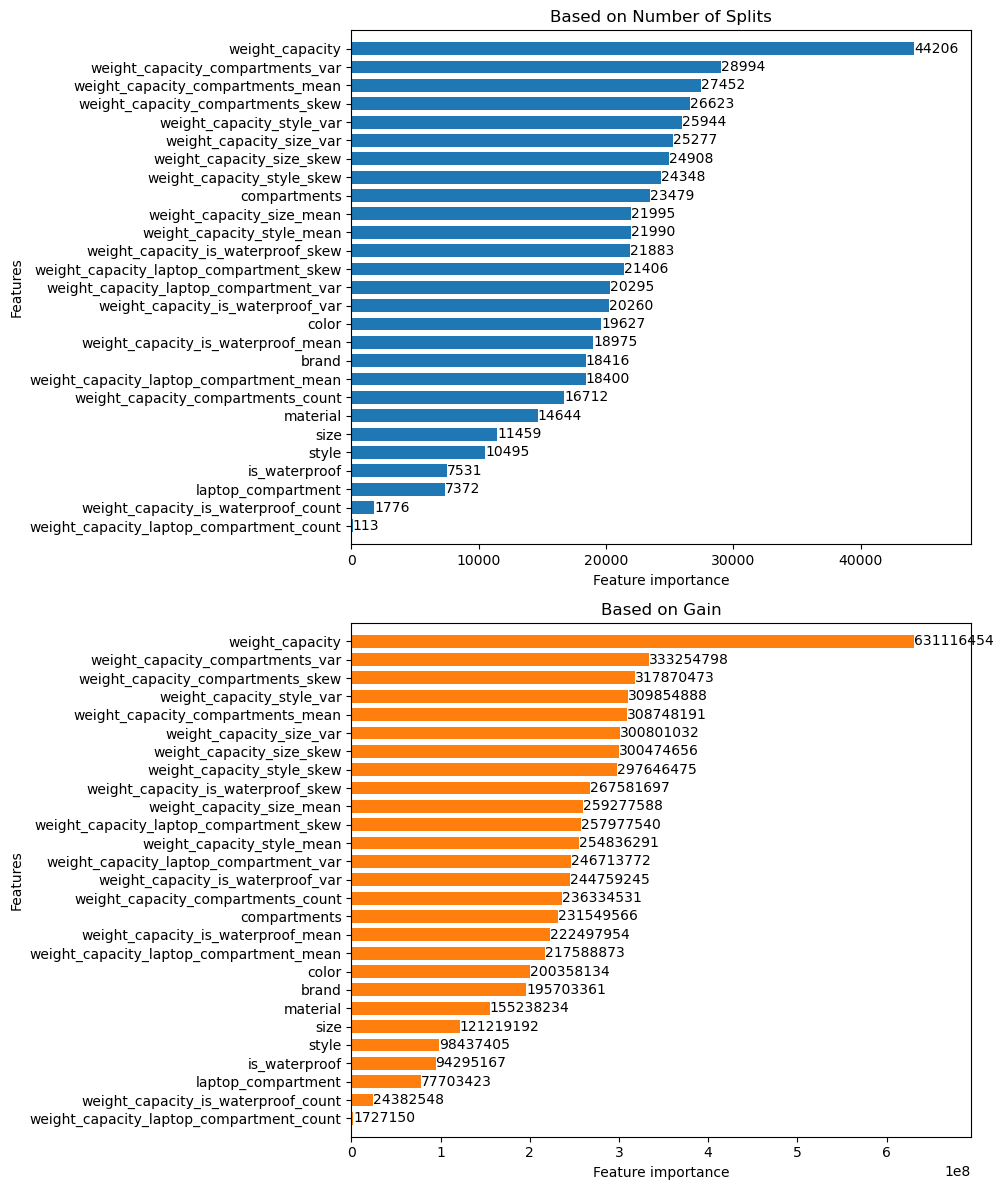

In [132]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()

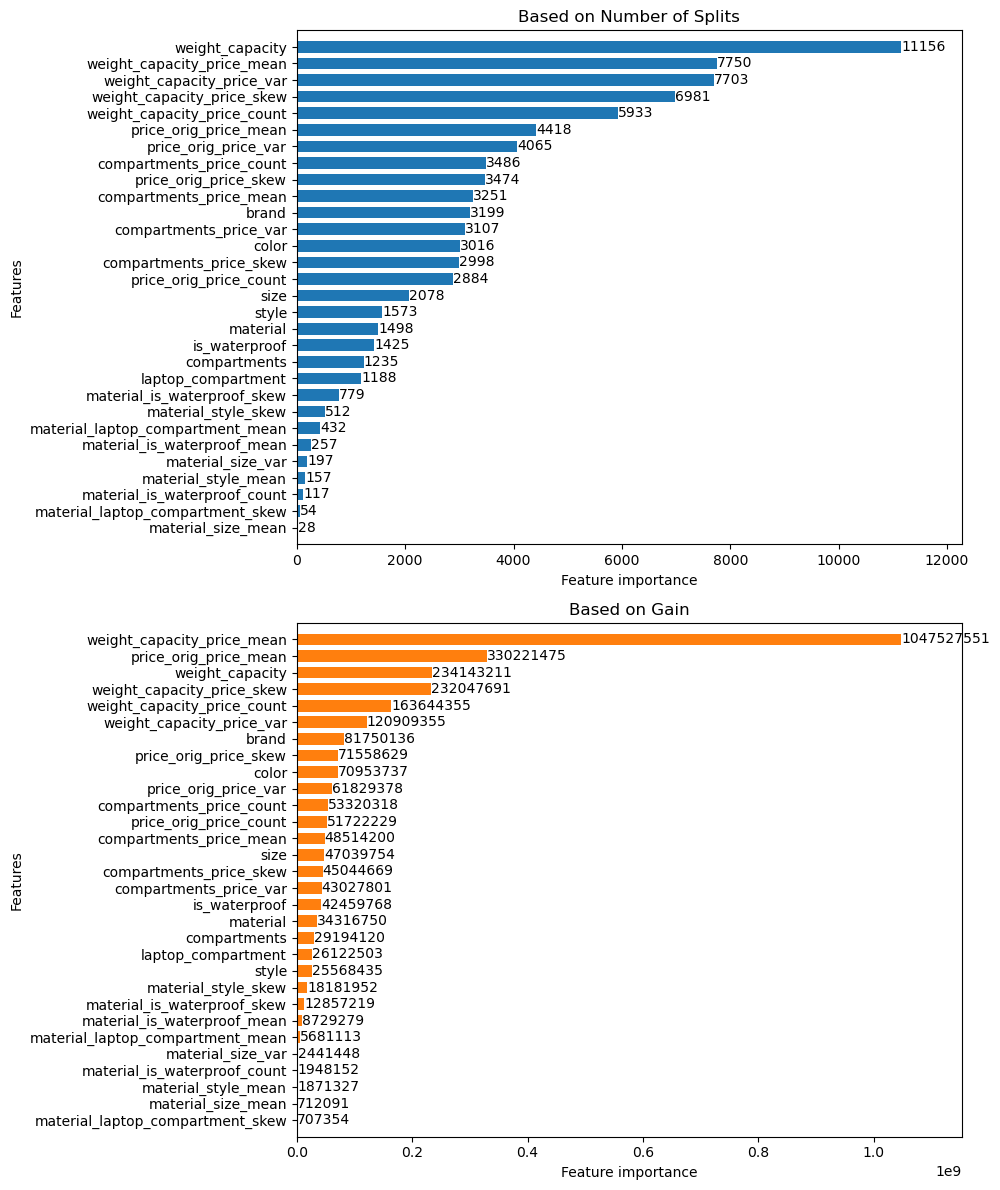

In [93]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()

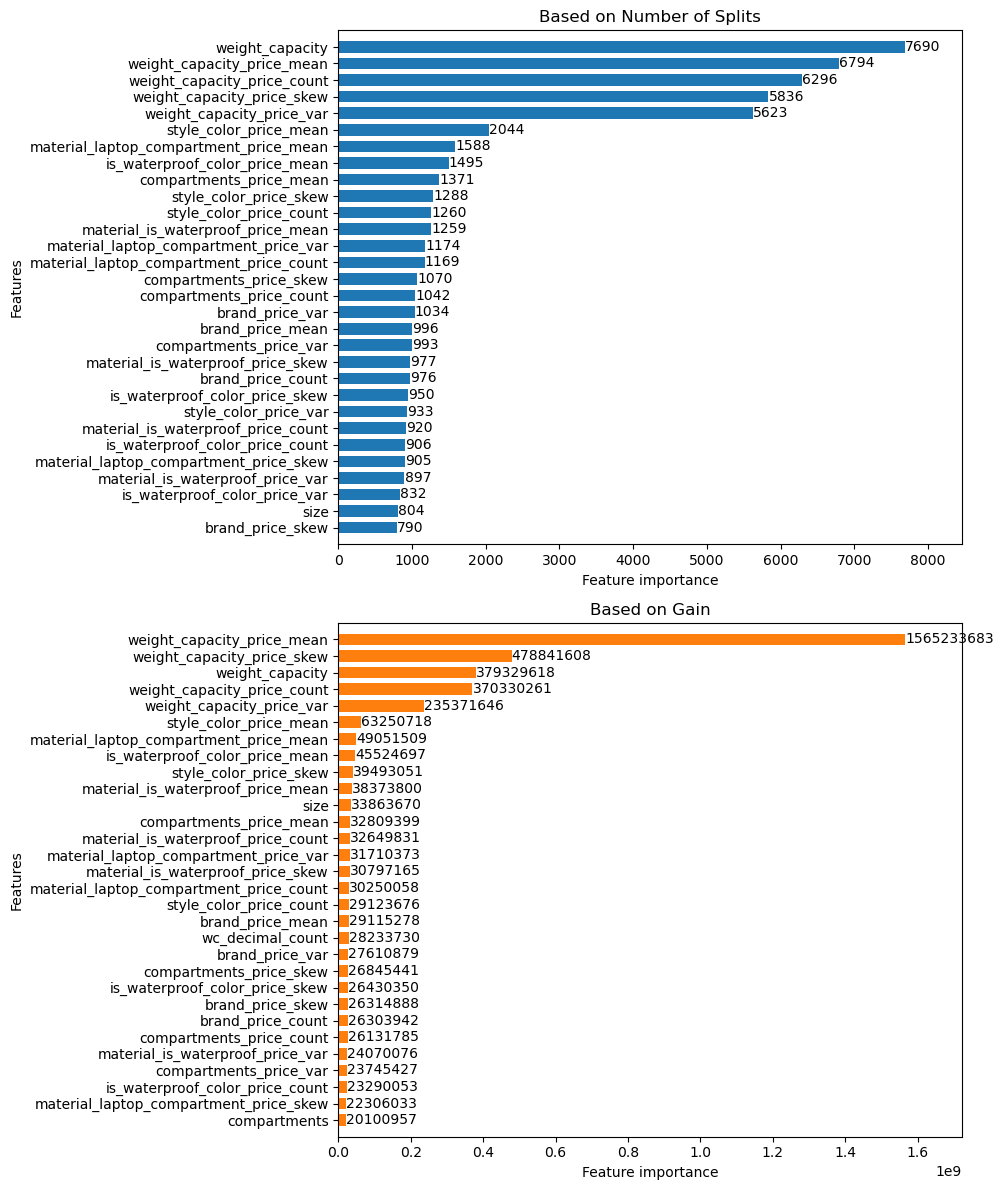

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()